In [22]:
import csv
import functools
import gzip
import pandas as pd
import json
import tempfile
import gzip
import json
import tqdm
import mlflow
import torch.nn.functional as F

from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from tqdm.notebook import tqdm, trange
from gensim.models import KeyedVectors
from torch.utils.data import Dataset, DataLoader, IterableDataset
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import classification_report


In [23]:
#CORRER UNA VEZ
!mkdir ./data
!curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/glove.6B.50d.txt.gz -o ./data/glove.6B.50d.txt.gz
!curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/meli-challenge-2019.tar.bz2 -o ./data/meli-challenge-2019.tar.bz2
!tar jxvf ./data/meli-challenge-2019.tar.bz2 -C ./data/
!pip install mlflow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.9M  100 65.9M    0     0  10.3M      0  0:00:06  0:00:06 --:--:-- 9251k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  945M  100  945M    0     0  33.4M      0  0:00:28  0:00:28 --:--:-- 33.1M
meli-challenge-2019/
meli-challenge-2019/spanish.test.jsonl.gz
meli-challenge-2019/portuguese.validation.jsonl.gz
meli-challenge-2019/portuguese.train.jsonl.gz
meli-challenge-2019/spanish.train.jsonl.gz
meli-challenge-2019/spanish_token_to_index.json.gz
meli-challenge-2019/portuguese_token_to_index.json.gz
meli-challenge-2019/spanish.validation.jsonl.gz
meli-challenge-2019/portuguese.test.jsonl.gz


In [2]:
data = []

df = pd.read_json(f"../data/meli-challenge-2019/spanish.train.jsonl.gz", lines=True)
data.append(df)

data = pd.concat(data, ignore_index=True)
data

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280
...,...,...,...,...,...,...,...,...,...,...
4895275,spanish,unreliable,Kit 2 Bieletas Delanteras Monroe Vw Fox 1.6 - ...,SWAY_BAR_LINKS,train,"[kit, bieletas, delanteras, monroe, fox]","[521, 4798, 9027, 3896, 593]",28,632,4895280
4895276,spanish,unreliable,Organo Teclado Casio Ct-x5000 61 Teclas Profes...,MUSICAL_KEYBOARDS,train,"[organo, teclado, casio, teclas, profesional, ...","[104, 30, 101, 6035, 962, 769]",24,632,4895280
4895277,spanish,reliable,Mochila Impermeable Belvento Fausto,BACKPACKS,train,"[mochila, impermeable, belvento, fausto]","[337, 2560, 1, 4711]",74,632,4895280
4895278,spanish,unreliable,Mochila San Lorenzo De Espalda 16p Sl001,BACKPACKS,train,"[mochila, san, lorenzo, espalda]","[337, 2125, 4974, 335]",74,632,4895280


In [3]:
df_datashort = data[:1000]

In [4]:
df_datashort.target.value_counts().sort_values()
# df_datashort

452    1
428    1
429    1
430    1
451    1
      ..
158    7
159    7
260    7
273    7
73     8
Name: target, Length: 453, dtype: int64

<AxesSubplot:xlabel='target', ylabel='Density'>

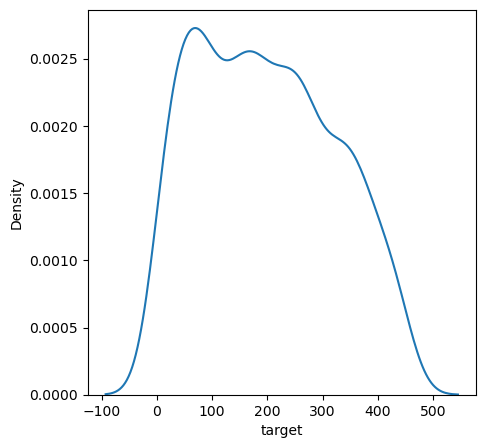

In [5]:
fig = plt.figure(figsize=(5,5))

sns.kdeplot(data=df_datashort, x=df_datashort.target)

In [6]:
df_category = df_datashort.groupby('category').mean().round(3).sort_values('target', ascending=True)
df_category.reset_index(inplace=True)
df_category

,category,target,n_labels,size
0,DOLLHOUSES,0.0,632.0,4895280.0
1,TOILETRY_BAGS,1.0,632.0,4895280.0
2,CAR_SEAT_COVERS,2.0,632.0,4895280.0
3,AUTOMOTIVE_CLUTCH_KITS,3.0,632.0,4895280.0
4,CAMERA_BATTERIES,4.0,632.0,4895280.0
...,...,...,...,...
448,PIPES_AND_TUBES,448.0,632.0,4895280.0
449,CONCEALERS,449.0,632.0,4895280.0
450,COMPLETE_SKATEBOARDS,450.0,632.0,4895280.0
451,DRONES,451.0,632.0,4895280.0


In [7]:
df_datashort

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280
...,...,...,...,...,...,...,...,...,...,...
995,spanish,unreliable,Drone Dji Matrice 200 / 210 / 210 Rtk Z30xt Co...,DRONES,train,"[drone, dji, matrice, rtk, zxt, consultar, pre...","[3004, 3003, 3005, 3006, 1, 3002, 2735]",451,632,4895280
996,spanish,unreliable,Cable De Red Utp 1.5mts,NETWORK_CABLES,train,"[cable, red, utp, mts]","[297, 749, 889, 887]",63,632,4895280
997,spanish,unreliable,Wop 1,NON_CORRECTIVE_CONTACT_LENSES,train,[wop],[1],452,632,4895280
998,spanish,unreliable,Guitarra Acustica Fender Dobro Brown Derby Re...,ACOUSTIC_GUITARS,train,"[guitarra, acustica, fender, dobro, brown, der...","[319, 1463, 1466, 3009, 3007, 3008, 3010, 112]",281,632,4895280


In [15]:
df_datashort = df_datashort[['title','category']]

In [17]:
df_datashort

,title,category
0,Casita Muñecas Barbies Pintadas,DOLLHOUSES
1,Neceser Cromado Holográfico,TOILETRY_BAGS
2,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS
3,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS
4,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES
...,...,...
995,Drone Dji Matrice 200 / 210 / 210 Rtk Z30xt Co...,DRONES
996,Cable De Red Utp 1.5mts,NETWORK_CABLES
997,Wop 1,NON_CORRECTIVE_CONTACT_LENSES
998,Guitarra Acustica Fender Dobro Brown Derby Re...,ACOUSTIC_GUITARS


In [20]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
 #       self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        

        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [21]:
class MyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

NameError: name 'Dataset' is not defined

In [18]:
class IMDBReviewsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.dataset = pd.read_csv(path)
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()  # Deal with list of items instead of tensor
        
        item = {
            "data": self.dataset.iloc[item]["review"],
            "target": self.dataset.iloc[item]["sentiment"]
        }

        if self.transform:
            item = self.transform(item)
        
        return item

dataset = IMDBReviewsDataset(df_datashort)
print(f"Dataset loaded with {len(dataset)} elements")
print(f"Sample element:\n{dataset[0]}")

NameError: name 'Dataset' is not defined